In [332]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import matplotlib.patches as patches
import json
import csv
import os
#i=0 if no saveing =1 if csv file is new, =2 otherwise
i=0

In [333]:
#PARAMETERS
fileName=r'C:\Users\florydberg01\labscript-suite\userlib\labscriptlib\MOT\PARAMETERS'

f = open(fileName)
data = json.load(f)

current=data['current'] #A
current=6.5
TOF=data['TOF'] #us
ImgDuration= data['ImgDuration'] #us
MOT_TIME=data['MOT_TIME']
twoD_delay=data['threeD_delay']
f.close

MOT_FRQ=180
Power_MOT=16 #mW

###############################
ZeemanFrq=360 #MHz
ZeemanPwr=60 #mW 
###############################

acquisition='buboZeeman_151' #acquisition

####################################
Img_frq=114.0 #MHz
Imag_beam_Power=440e-6 #W
####################################

Waist2=0.006667*0.006667 #m
Isat=67.6
sat=2*Imag_beam_Power/np.pi/Waist2/Isat
sat=round(sat*100)/100
print(sat)

parameters='%sMHzx%sus_TOF=%sus(%sA,s=%s)'%(Img_frq, ImgDuration,TOF,current, sat)


0.09


In [334]:
# Load the multi-layer TIFF file

multi_layer_image = tiff.imread("%s.tif"%(acquisition))
xsize = multi_layer_image.shape[0]
x=np.arange(xsize)

idxA = x[0:xsize:3]
idxI = x[1:xsize:3]
idxB = x[2:xsize:3]

# idxD = x[0:xsize:4]

# Split the multi-layer TIFF into individual images
absorption_image = np.average(multi_layer_image[idxA].astype(np.float32),axis=0)
imaging_beam_image = np.average(multi_layer_image[idxI].astype(np.float32),axis=0)
background_image = np.average(multi_layer_image[idxB].astype(np.float32),axis=0)

# MOT_image=np.average(multi_layer_image[idxD].astype(np.float32),axis=0)

intensity correction: 1.0064141750335693


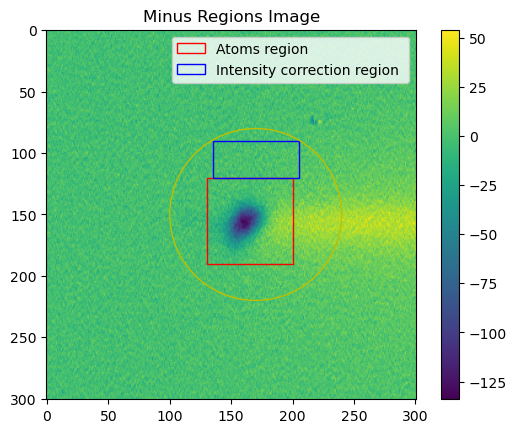

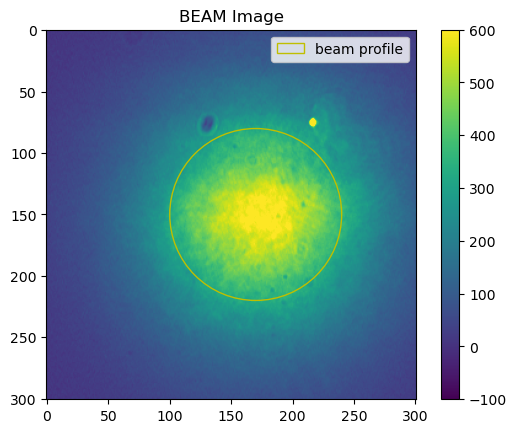

In [335]:
# Constants and Image Analysis
image_size = background_image.shape
absorption_coefficient = 0.02
pixel_size = 13  # micrometers per pixel
atom_mass = 1.67*88e-27  # mass of a single atom (in kilograms)
pix=13e-6*125/50
S=pix*pix
sigma=9.7e-14
lam = 461*1e-9
delta=1
Gam=1
sig=3*lam**2/2/np.pi*(1/(1+(2*delta/Gam)**2))*1/(1+sat)
# print(sig)
# Calculate the optical density
up=(absorption_image-background_image)
down=(imaging_beam_image-background_image)

down[down<=1] = 1
up[up<=1] = 1

P0=(130,120)
RX=70
RY=70

DX=(P0[0], P0[0]+RX)
DY=(P0[1], P0[1]+RY)

MOT=patches.Rectangle(P0, RX, RY, linewidth=1, edgecolor='r', facecolor='none') 

p0=(135,90)
rX=70
rY=30

dX=(p0[0], p0[0]+rX)
dY=(p0[1], p0[1]+rY)

corr=patches.Rectangle(p0, rX, rY, linewidth=1, edgecolor='b', facecolor='none')

b0=(170,150)
ray=70
BEAM=patches.Circle(b0, ray, linewidth=1, edgecolor='y', facecolor='none') 
BEAM1=patches.Circle(b0, ray, linewidth=1, edgecolor='y', facecolor='none') 

Ia=np.sum(up[np.ix_(range(dY[0],dY[1]),range(dX[0],dX[1]))])
Ib=np.sum(down[np.ix_(range(dY[0],dY[1]),range(dX[0],dX[1]))])
intensity_correction=Ia/Ib

print(f"intensity correction: {intensity_correction}")
plt.gca().add_patch(MOT)
plt.gca().add_patch(corr)
plt.gca().add_patch(BEAM)

plt.imshow(up/intensity_correction-down, cmap='viridis')
plt.colorbar()
plt.title('Minus Regions Image')
plt.legend(['Atoms region ', 'Intensity correction region '])
plt.show()

plt.gca().add_patch(BEAM1)
plt.imshow(down, cmap='viridis', vmin=-100, vmax=600 )
plt.colorbar()
plt.title('BEAM Image')
plt.legend(['beam profile'])
plt.show()

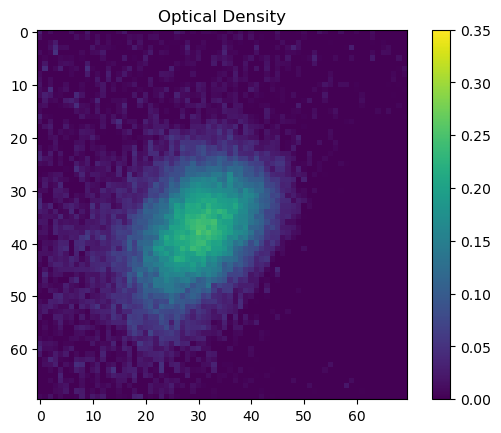

atoms 1409381.5
Number of atoms in the cloud: 1.41e+06


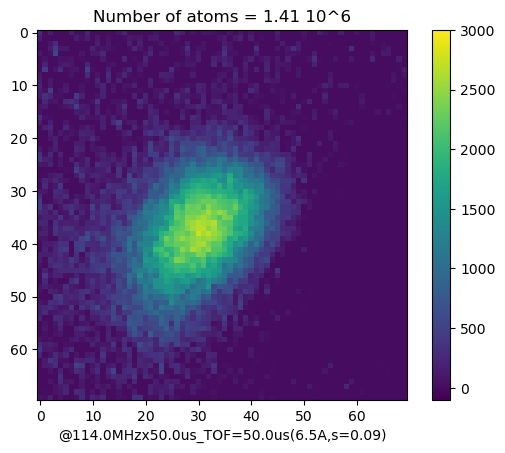

In [336]:
# Calculate the Optical Density

optical_density = -1 *np.log((up/down)/intensity_correction)
optical_density[optical_density<0]=0
# optical_density[down<50]=0

OD=optical_density[np.ix_(range(DY[0],DY[1]),range(DX[0],DX[1]))]

plt.imshow(OD, cmap='viridis', vmin=0, vmax=0.35 )
plt.colorbar()
plt.title('Optical Density')
plt.savefig("Atoms@%s.png"%(parameters))
plt.show()

natoms = S/sigma*OD
number_of_atoms = np.sum(natoms) # Total number of atoms in the cloud
print('atoms', number_of_atoms )
print(f"Number of atoms in the cloud: {number_of_atoms:.2e}")

plt.imshow(natoms, cmap='viridis', vmin=-100, vmax=3000 )
plt.colorbar()
name=('Number of atoms = %s 10^6'%(round(number_of_atoms/10000)/100))
plt.title(name)
plt.xlabel('@%s'%(parameters))
plt.savefig("Atoms@%s.png"%(parameters))
plt.show()

np.save("%sAtoms"%(acquisition), natoms, allow_pickle=True, fix_imports=True)

######## REDUCED ROI ####################################################################
# pp0=(60,55)
# rrX=20
# rrY=20

# ddX=(pp0[0], pp0[0]+rrX)
# ddY=(pp0[1], pp0[1]+rrY)

# catoms= S/sigma*OD[np.ix_(range(ddY[0],ddY[1]),range(ddX[0],ddX[1]))]
# central_atoms=np.sum(catoms) # Reduced number of atoms in the cloud
# print('central_atoms', central_atoms)
# ROI=patches.Rectangle(pp0, rrX, rrY, linewidth=1, edgecolor='r', facecolor='none') 
# # plt.gca().add_patch(ROI)

# plt.imshow(natoms, cmap='viridis', vmin=-100, vmax=1500 )
# plt.colorbar()
# name=('Number of central atoms=%s 10^3'%(round(central_atoms/100)/10))
# plt.title(name)
# plt.xlabel('@%s'%(parameters))
# plt.legend(['Cloud Central Atoms'])
# plt.savefig("CentralAtoms@%s.png"%(parameters))
# plt.show()



Amplitude: 2612.301775021613
Center (x, y): 30.905109756424856 31.44479814093713
Standard Deviations (σ_x, σ_y): 10.972112526362743 7.241582629101315
Theta: 0.29 π 
Number of atoms: 1303054.6428242105


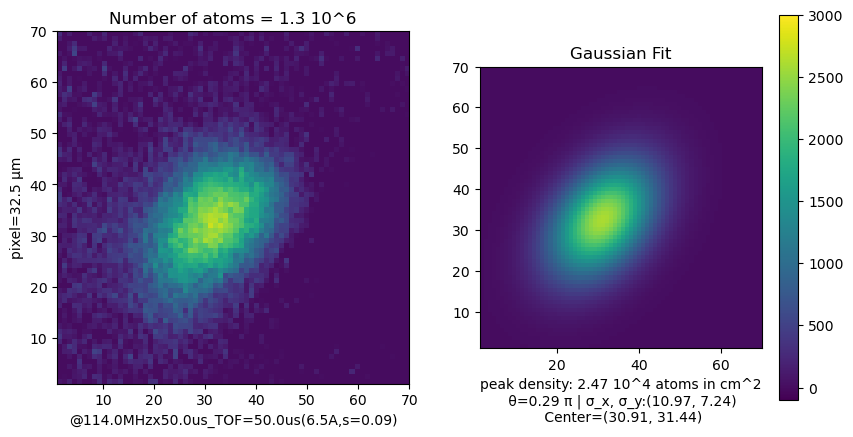

In [340]:
##FITTING on GAUSSIAN

from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, th):
    theta=th*np.pi
    x, y = xy
    xo = float(xo)
    # xo=30
    yo = float(yo)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    return amplitude * np.exp(-(a * (x - xo)**2 + 2 * b * (x - xo) * (y - yo) + c * (y - yo)**2))

x = np.linspace(1, RX, RX)
y = np.linspace(1, RY, RY)
xx, yy = np.meshgrid(x, y)
X=xx.ravel(order='F')
Y=yy.ravel(order='F')


# Fit the 2D Gaussian to the image
initial_guess = (1000, 35, 35, 15, 15, 0.25)  # Initial guess for amplitude, xo, yo, sigma_x, sigma_y, theta
low=[0,0,0,5,5,0]
upper=[float('inf'),float('inf'),float('inf'),RX,RY,0.50]
bounds=[low, upper]
popt, _ = curve_fit(gaussian_2d, (X,Y), natoms.ravel(order='F'), p0=initial_guess, bounds=bounds)

# Extract the parameters
amplitude, xo, yo, sigma_x, sigma_y, theta = popt


# Print the fitted parameters
print("Amplitude:", amplitude)
print("Center (x, y):", xo, RY-yo)
print("Standard Deviations (σ_x, σ_y):", sigma_x, sigma_y)
print("Theta: %s π " %(round(theta*100)/100) )

# Generate the fitted Gaussian distribution
fit_data = gaussian_2d((X,Y), *popt)
fitdata=fit_data.reshape((RY,RX), order='F')

fitN_of_atoms = np.sum(fitdata)
print('Number of atoms:', fitN_of_atoms)

#########################  Plot the original data and the fitted Gaussian  ####################
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
name=('Number of atoms = %s 10^6'%(round(fitN_of_atoms/10000)/100))
plt.title(name)
density=amplitude/S*1e-8 #in cm^2
plt.xlabel('@%s'%(parameters))
plt.ylabel('pixel=32.5 µm')
plt.imshow(natoms, cmap='viridis', vmin=-100, vmax=3000, extent=(x.min(), x.max(), y.min(), y.max()))

plt.subplot(1, 2, 2)
plt.imshow(fitdata, cmap='viridis',vmin=-100, vmax=3000, extent=(x.min(), x.max(), y.min(), y.max()))
plt.title('Gaussian Fit')
plt.xlabel('peak density: %s 10^4 atoms in cm^2\n θ=%s π | σ_x, σ_y:(%s, %s)\n Center=(%s, %s)' 
            %(round(density/100)/100, round(theta*100)/100, round(sigma_x*100)/100, round(sigma_y*100)/100, 
            round(xo*100)/100, round((RY-yo)*100)/100))
plt.colorbar()
plt.savefig("FitAtoms@%s.png"%(acquisition))
plt.show()

############################################ SAVINGS ##########################################################################
if i>0:
    file_name=('MOTZeeman.csv')

    if i==1:
        if os.path.exists(file_name):
            os.remove(file_name)

    with open(file_name, 'a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        if i==0:
            writer.writerow(['acquisition','number_of_atoms', 'central_atoms','fit_number_atoms', 'density', 'current', 
                            'Img_frq','Imag_beam_Power', 'saturation', 'TOF', 'xo', 'yo', 'twoD_delay','MOT_FRQ', 'Power_MOT', 
                            'ZeemanFrq', 'ZeemanPwr'])
            i=1
        writer.writerow([acquisition, int(number_of_atoms), int(central_atoms),  int(fitN_of_atoms), int(density), current, 
                        Img_frq, Imag_beam_Power*1e6, sat, TOF, xo, yo, twoD_delay, MOT_FRQ, Power_MOT, 
                        ZeemanFrq, ZeemanPwr])

